Loading train, test and valid data from LIAR dataset


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd

In [6]:
data_train = pd.read_csv("/content/drive/MyDrive/fakenews/fakenews/train.tsv", sep="\t", header=None)
data_valid = pd.read_csv("/content/drive/MyDrive/fakenews/fakenews/valid.tsv", sep="\t", header=None)
data_test = pd.read_csv("/content/drive/MyDrive/fakenews/fakenews/test.tsv", sep="\t", header=None)

data_train[1] = data_train[1].map({"pants-fire" : 0, "false" : 0, "barely-true" : 0, "half-true" : 2, "mostly-true" : 1, "true" : 1})
data_valid[1] = data_valid[1].map({"pants-fire" : 0, "false" : 0, "barely-true" : 0, "half-true" : 2, "mostly-true" : 1, "true" : 1})
data_test[1] = data_test[1].map({"pants-fire" : 0, "false" : 0, "barely-true" : 0, "half-true" : 2, "mostly-true" : 1, "true" : 1})

Data Preprocessing

In [7]:
#Below function performs all the required data cleaning and preprocessing steps

def data_preprocessing(dataset):
  
  #Dropping unwanted columns
  dataset = dataset.drop(labels=[0,8,9,10,11,12] ,axis=1)
  #Dealing with empty datapoints for metadata columns - subject, speaker, job, state,affiliation, context


 
  # reanming the DataFrame columns
  data_train.rename(columns = { 1 :'label'},
			inplace = True)
  data_valid.rename(columns = { 1 :'label'},
			inplace = True)
  data_test.rename(columns = { 1 :'label'},
			inplace = True)
    
 
  
  
  dataset["sentence"] = dataset[2] #Combining metadata and the text columns into single columns
  
  dataset = dataset.drop([2,3,4,5,6,7,13], axis=1) #dropping metadata columns, as we have merged them into a single column
  dataset.dropna() #Dropping if there are still any null values

  return dataset


In [8]:
#Applying pre-processing to the raw data - train, valid and test sets
data_train = data_preprocessing(data_train)
data_valid = data_preprocessing(data_valid)
data_test = data_preprocessing(data_test)

In [9]:
#Sample data after preprocessing
data_train.head(5)

,label,sentence
0,0,Says the Annies List political group supports ...
1,2,When did the decline of coal start? It started...
2,1,"Hillary Clinton agrees with John McCain ""by vo..."
3,0,Health care reform legislation is likely to ma...
4,2,The economic turnaround started at the end of ...


Analyzing the distribtuion of labels in each dataset


In [10]:
data_train['label'].value_counts()

0    4488
1    3638
2    2114
Name: label, dtype: int64

In [11]:
data_valid['label'].value_counts()

0    616
1    420
2    248
Name: label, dtype: int64

In [12]:
data_test['label'].value_counts()

0    553
1    449
2    265
Name: label, dtype: int64

We can see that all the datasets have almost equal distribution of real and fake categories

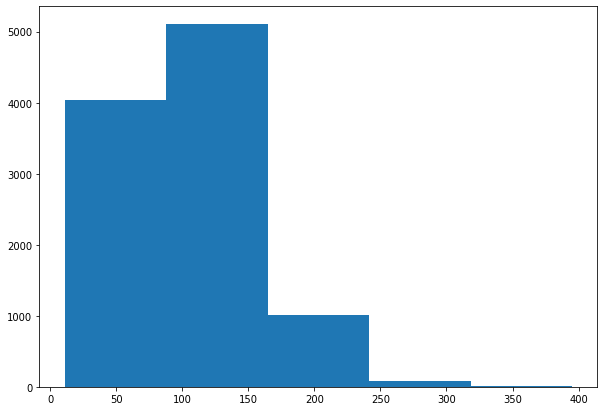

In [13]:
#Analyzing length of sentences in training data to decide on MAX_LENGTH variable, which is required for BERT and RoBERTa

sent_len = []
for sent in data_train['sentence']:
  sent_len.append(len(sent))

import matplotlib.pyplot as plt


sent_len = [i for i in sent_len if i<=500] #Excluding the outliers
fig2 = plt.figure(figsize =(10, 7))
plt.hist(sent_len, 5)
plt.show()

From the above histogram, we can see that, majority of the sentences are in the range of 150-250 and most of the sentences length is less than 350

Installing required library - transformers

In [14]:
!pip install transformers==4.21.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 106.3 MB/s eta 0:00:00


In [15]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 35.4 MB/s eta 0:00:0

In [16]:
#importing required packages  
from transformers import (
    BertForSequenceClassification,    
    BertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    AdamW)



In [17]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow.keras.backend as K
from scipy.stats import spearmanr
from math import floor, ceil

import shutil

from official.nlp import optimization  # to create AdamW optmizer

np.set_printoptions(suppress=True)


In [19]:
#from transformers import *

In [20]:
train_ds = tf.data.Dataset.from_tensor_slices((data_train.sentence.values, data_train.label.values))
val_ds = tf.data.Dataset.from_tensor_slices((data_valid.sentence.values, data_valid.label.values))
test_ds = tf.data.Dataset.from_tensor_slices((data_test.sentence.values, data_test.label.values))

In [21]:
train_ds = train_ds.shuffle(len(data_train)).batch(32, drop_remainder=False)
val_ds = val_ds.shuffle(len(data_valid)).batch(32, drop_remainder=False)
test_ds = test_ds.shuffle(len(data_test)).batch(32, drop_remainder=False)

In [22]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 
#bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/1',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1


In [23]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [24]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [25]:
def build_CNN_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    #net = outputs['pooled_output'] # [batch_size, 768].
    net = sequence_output = outputs["sequence_output"] # [batch_size, seq_length, 768]
      
    
    net = tf.keras.layers.Conv1D(32, (3), activation='relu')(net)
    #net = tf.keras.layers.MaxPooling1D(5)(net)
    
    net = tf.keras.layers.Conv1D(64, (3), activation='relu')(net)
    #net = tf.keras.layers.MaxPooling1D(2)(net)
    net = tf.keras.layers.GlobalMaxPool1D()(net)
    
#    net = tf.keras.layers.Flatten()(net)
    
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    
    net = tf.keras.layers.Dropout(0.1)(net)
#   net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier')(net)
    
    return tf.keras.Model(text_input, net)

In [26]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(1):
    tweet = text_batch.numpy()[i]
    print(f'Tweet: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')

text_test = ['this is such an amazing movie!']
text_test = [tweet]


text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Tweet: b'The Senate proposal to restore emergency unemployment benefits for five months was fully paid for.'
Label : 0
Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  1996  4001  6378  2000  9239  5057 12163  6666  2005  2274  2706]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [27]:
cnn_classifier_model = build_CNN_classifier_model()
bert_raw_result = cnn_classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


tf.Tensor([[0.6144891  0.57674384 0.5558553 ]], shape=(1, 3), dtype=float32)


In [28]:
cnn_classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

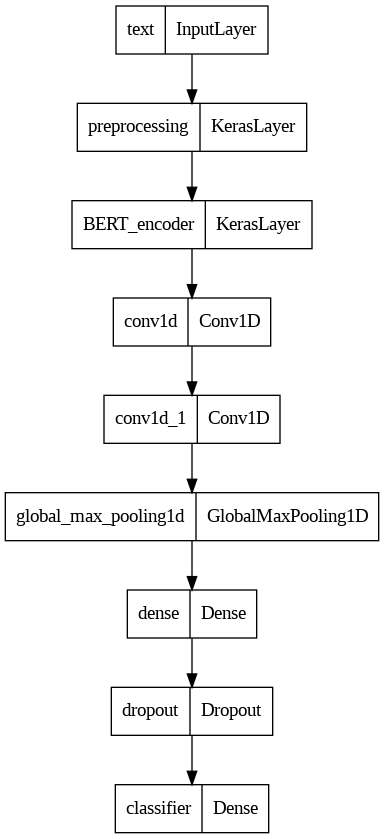

In [29]:
tf.keras.utils.plot_model(cnn_classifier_model)

In [30]:
tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [31]:
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

cnn_classifier_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy'))

In [32]:
print(f'Training model with {tfhub_handle_encoder}')
cnn_history = cnn_classifier_model.fit(x=train_ds,
                                       validation_data=val_ds,
                                       epochs=epochs,
                                       
                                      )

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/3


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


320/320 [==============================] - 87s 240ms/step - loss: 1.0475 - accuracy: 0.4627 - val_loss: 0.9965 - val_accuracy: 0.5148
Epoch 2/3
320/320 [==============================] - 74s 232ms/step - loss: 1.0112 - accuracy: 0.5055 - val_loss: 0.9822 - val_accuracy: 0.5265
Epoch 3/3
320/320 [==============================] - 75s 233ms/step - loss: 0.9839 - accuracy: 0.5303 - val_loss: 0.9774 - val_accuracy: 0.5249


In [33]:
loss, accuracy = cnn_classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

40/40 [==============================] - 4s 105ms/step - loss: 1.0054 - accuracy: 0.5083
Loss: 1.0054407119750977
Accuracy: 0.5082873106002808


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


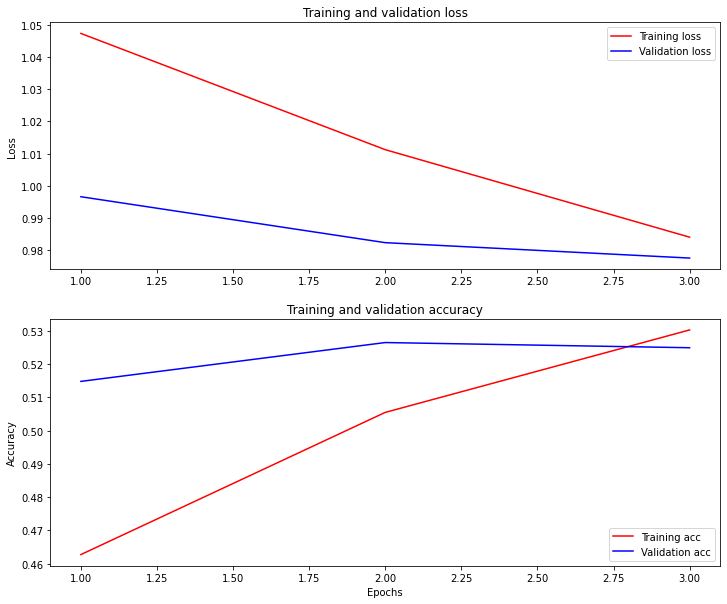

In [34]:
history_dict = cnn_history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
# acc = history_dict['binary_accuracy']
# val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [35]:
result =  cnn_classifier_model.predict(test_ds)
print(result.shape)

40/40 [==============================] - 5s 98ms/step
(1267, 3)


In [36]:
result[0:2]

array([[0.35623854, 0.3950114 , 0.24875002],
       [0.4523205 , 0.27325007, 0.27442947]], dtype=float32)

In [37]:
classes = np.argmax(result, axis=-1)

In [38]:
tweet = []
test_labels = []
predictions = []
for tweet, labels in test_ds.take(-1):
  tweet = tweet.numpy()
  test_labels.append(labels.numpy())
  predictions.append(cnn_classifier_model.predict(tweet))

1/1 [==============================] - 1s 710ms/step


In [39]:
test_labels[0:2]

[array([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 0, 0, 1, 1, 2, 2, 0, 0,
        1, 0, 0, 2, 0, 0, 0, 0, 0, 1]),
 array([0, 0, 1, 2, 0, 0, 1, 0, 2, 0, 1, 1, 2, 0, 0, 2, 0, 1, 2, 0, 0, 0,
        1, 1, 1, 2, 1, 1, 1, 1, 0, 0])]

In [40]:
predictions[0:2]

[array([[0.39754632, 0.28133413, 0.32111952],
        [0.30438626, 0.55268896, 0.1429248 ],
        [0.31277624, 0.43430796, 0.25291577],
        [0.26375437, 0.5352001 , 0.20104551],
        [0.4774302 , 0.34191892, 0.18065089],
        [0.25397214, 0.5143212 , 0.23170665],
        [0.33725813, 0.36404938, 0.2986925 ],
        [0.5858439 , 0.16516948, 0.24898662],
        [0.5365857 , 0.2986367 , 0.16477764],
        [0.37402818, 0.45505172, 0.17092013],
        [0.38098416, 0.5084879 , 0.11052803],
        [0.3071215 , 0.5284141 , 0.16446449],
        [0.24212454, 0.6219759 , 0.13589962],
        [0.23124546, 0.5355976 , 0.2331569 ],
        [0.36323556, 0.45857018, 0.17819422],
        [0.28804672, 0.4954753 , 0.21647795],
        [0.42995656, 0.3556197 , 0.21442375],
        [0.29254705, 0.55028564, 0.15716729],
        [0.5635852 , 0.15647548, 0.27993923],
        [0.51929724, 0.15244515, 0.32825762],
        [0.54795635, 0.17699797, 0.27504566],
        [0.27628946, 0.47013977, 0

In [41]:
from itertools import chain
flatten_list = list(chain.from_iterable(predictions))
y_pred = np.argmax(flatten_list, axis=-1)

In [42]:
type(y_pred)

numpy.ndarray

In [43]:
y_test = np.array(list(chain.from_iterable(test_labels)))

In [44]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[401, 150,   2],
       [204, 243,   2],
       [168,  97,   0]])